In [2]:
import numpy as np

import matplotlib.pyplot as plt

import ipdb

In [5]:
def make_signal(w,theta,n,skip=1,shift=0):
    """
    Assumes normalized amplitude
    """
    t = np.arange(0,n*skip,skip)+shift
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,n):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
    return noise

def make_noisy_signal(w,theta,sigma2,n,skip=1):
    signal = make_signal(w,theta,n,skip)
    noise  = make_noise(sigma2,n)
    return signal + noise

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = (3.0/2)*N/(N**2 - 1)
    w = [1 - ((i - (N/2 - 1))/(N/2))**2 for i in range(N-1)]
    return scaling*np.array(w)

def kays_method(my_signal):
    N = len(my_signal)
    w = kay_weights(N)
    
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    need_to_shift = np.any(angle_diff < -np.pi/2)
    if need_to_shift:    
        neg_idx = angle_diff < 0
        angle_diff[neg_idx] += np.pi*2
    
    return w.dot(angle_diff)

def successive_estimation(signal_chain,N):
    location_bis = 0
    num_chains = len(signal_chain)
    # from radians to location
    factor = N/2/np.pi
    # how many frequencies wrap to the location
    nwrap = 1
    
    for chain in signal_chain:
        temp_location = (kays_method(chain)*factor) %  N
        
        loc_update = temp_location/nwrap - location_bis
        
        r = loc_update - round((loc_update * nwrap)/N)*N/nwrap
        
        location_bis += r
        nwrap *= 2
        
    return location_bis % N

In [6]:
A = make_kay_chains(w0,
                        1,
                        num_delays_per_chain,
                        snrdb)

NameError: name 'make_kay_chains' is not defined

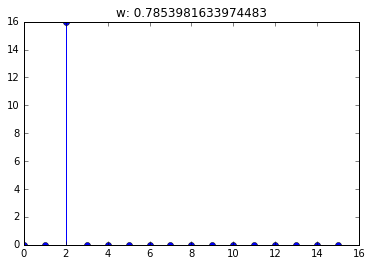

In [7]:
N = 16
f0 = 2
w0 = (2*np.pi)*f0/N % (2*np.pi)


my_signal = make_signal(w0,0,N)
my_signal_fft = np.fft.fft(my_signal)

plt.stem(np.abs(my_signal_fft))
plt.title('w: {}'.format(w0))
plt.show()

In [8]:
def omega_to_location(w,N):
    return w*N/2/np.pi

In [9]:
omega_to_location(kays_method(my_signal),N)

2.0000000000000004

In [10]:
def make_kay_chains(w0,num_chains,num_samples_per_chain,snrdb):
    # this is a list of arrays
    # it has num_chains many elements
    # each element is an array of length num_samples_per_chain
    chains = []
    # noise variance
    sigma2 = get_sigma2_from_snrdb(snrdb)
    
    for i in range(num_chains):
        # first chain gets samples with skipping 1
        # second chain gets samples with skipping 2, etc...
        skip = 2**i
        # skip needs to be passed
        signal = make_signal(w0,0,num_samples_per_chain,skip)
        noise  = make_noise(sigma2,num_samples_per_chain)
        noisy_signal = signal + noise
        # append to the chain
        chains.append(noisy_signal)
    return chains

In [11]:
def make_our_chains(w0,
                      n,
                      num_samples_per_chain,
                      snrdb):
    '''
    n = what power of two is the signal
    '''
    # chains is a list of lists
    # it has n elements
    # each element is a list of tuples (sample1, sample2)
    chains = []
    # sampling_points is a list of lists
    # it has n elements
    # each element is a list of tuples (sampling_location_1, sampling_location_2)
    sampling_points = []
    sigma2 = get_sigma2_from_snrdb(snrdb)
    
    # you start by skipping signal_length/2
    skip = 2**(n-1)
    
    for i in range(n):
        current_chain = []
        current_sampling_points = []
        
        # poisition of the first sample
        shift = 0
        for i in range(num_samples_per_chain):
            signal = make_signal(w0,0,2,skip,shift)
            noise  = make_noise(sigma2,2)
            noisy_signal = signal + noise
            current_chain.append(tuple(noisy_signal))
            current_sampling_points.append(tuple([shift,shift+skip]))
            shift += 1
        chains.append(current_chain)
        sampling_points.append(current_sampling_points)
        # halve the skip
        skip /= 2
    return chains, sampling_points

In [12]:
def estimate_bit(chain,
                 sampling_points,
                 ref_w0):
    '''
    chain: pairs of samples obtained from the chain
    sampling_points: the points at which the samples are obtained
    ref_w0: the reference frequency obtained so far
    '''
    # complex valued estimate of the sign
    d = 0
    # number of pairs in a chain
    len_chain = len(chain)
    # go over the chain
    for i in range(len_chain):
        # where the samples are taken
        s1,s2 = sampling_points[i]
        # the sample values
        a,b = chain[i]
        # rotate the frequency based on the reference
        a = a*np.exp(-1j*ref_w0*s1)
        b = b*np.exp(-1j*ref_w0*s2)
        # check the sign
        d += b*np.conj(a)
    # average the sign
    # (this would change if there is a covariance between estimates)
    # (we get around this by taking non-overlapping samples)
    d /= len_chain
    # sign (returns -1 or 1)
    return np.sign(np.real(d))

def our_method(all_chains, all_sampling_points):
    # start with reference 0
    ref_w0 = 0
    n = len(all_chains)
    # signal length
    N = 2**n
    # go over chains
    for i in range(n):
        current_chain = all_chains[i]
        current_smapling_points = all_sampling_points[i]
        # estimate the bit
        current_bit = estimate_bit(current_chain,
                                   current_smapling_points,
                                   ref_w0)
        # if the current bit is -1 it means we are odd with
        # respect to ith bit of the frequency
        if current_bit == -1:
            ref_w0 += (2**i)*(2*np.pi)/N
    return ref_w0

In [309]:
# for testing the successive estimation or kay's method
n = 10
N = 2**n
f0 = 80
w0 = (2*np.pi)*f0/N
snrdb = 6
num_delays_per_chain = 3

num_correct = 0
num_iter = 400

total_samples = n*num_delays_per_chain
print('total samples: {}'.format(total_samples))

for i in range(num_iter):
    # successive estimation ----
    A = make_kay_chains(w0, n, num_delays_per_chain, snrdb)
    # the one used in ffast paper
    a = successive_estimation(A,N)
    # --------------------------
    
    # original kay's method ----
#     a = omega_to_location(kays_method(make_kay_chains(w0, 1, total_samples, snrdb)[0]),N)
    # --------------------------
    
    b = round(a) % N
    num_correct += (b == f0)
    
print('success: {}'.format(num_correct/num_iter))

total samples: 30
success: 0.9275


In [51]:
# for testing our method
n = 14
N = 2**n
#f0 = 80
#w0 = (2*np.pi)*f0/N
snrdb = 0
#num_pairs_per_chain = n
pairs_per_chains = [n-6, n-4, n-2, n, n+2, n+4, n+6]

total_wrongs = []
accs = []

for num_pairs_per_chain in pairs_per_chains:
    num_correct = 0
    num_iter = 350000
    wrongs = [0] * N
    alls = [0] * N

    total_samples = n*2*num_pairs_per_chain
    print('total samples: {}'.format(total_samples))

    for i in range(num_iter):
        f0 = np.random.randint(0, N)
        alls[f0] += 1
        w0 = (2*np.pi)*f0/N
        A,B = make_our_chains(w0,n,num_pairs_per_chain,snrdb)
        w0_est = our_method(A,B)
        a = omega_to_location(w0_est, N)    
        b = round(a)
        num_correct += (b == f0)
        if b != f0:
            wrongs[b] += 1
    for i in range(len(wrongs)):
        wrongs[i] /= alls[i]
    total_wrongs.append(wrongs)

    print('success: {}'.format(num_correct/num_iter))
    accs.append(num_correct/num_iter)

total samples: 224
success: 0.9241114285714286
total samples: 280
success: 0.96772
total samples: 336
success: 0.9865742857142857
total samples: 392
success: 0.9943028571428572
total samples: 448
success: 0.99744
total samples: 504
success: 0.9988828571428572
total samples: 560
success: 0.9995828571428571


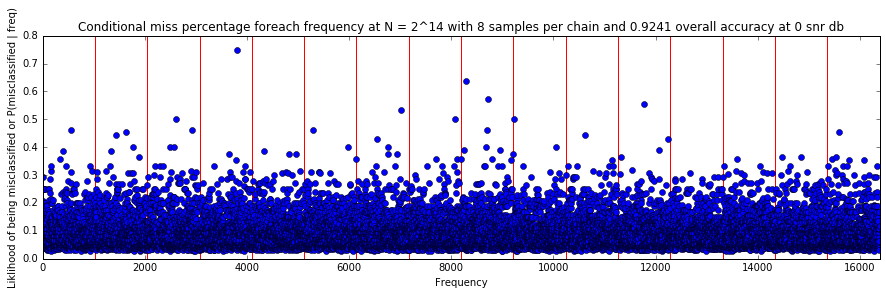

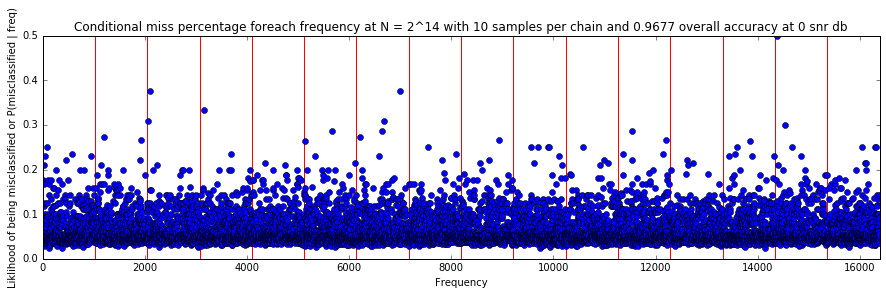

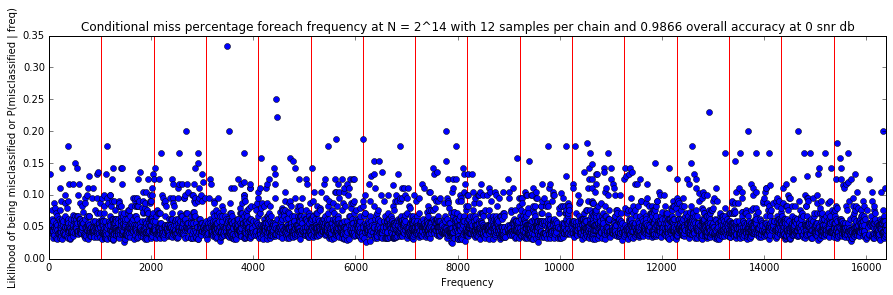

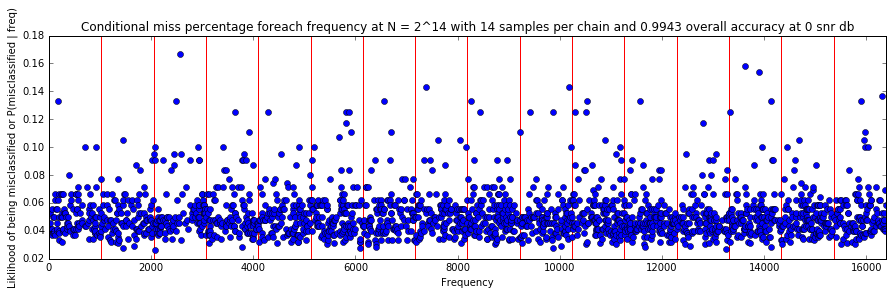

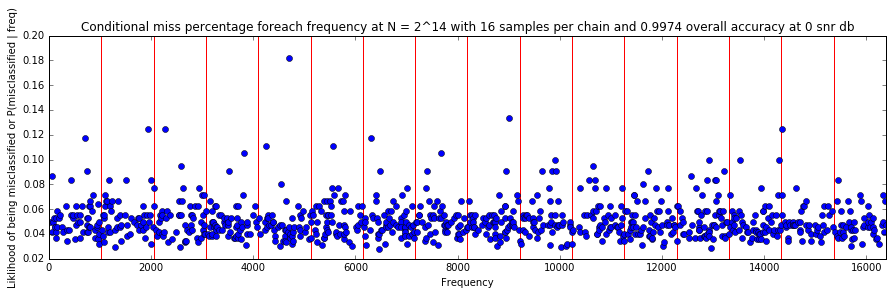

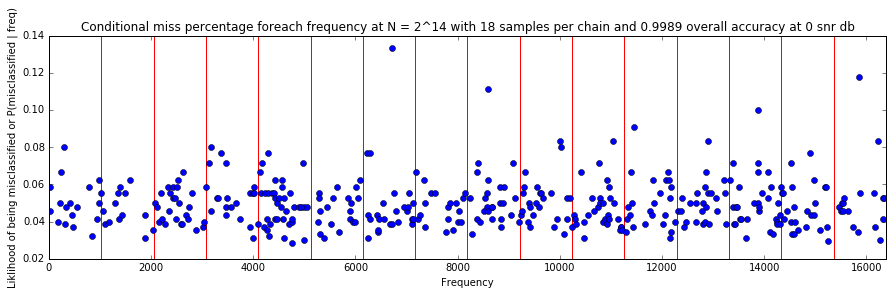

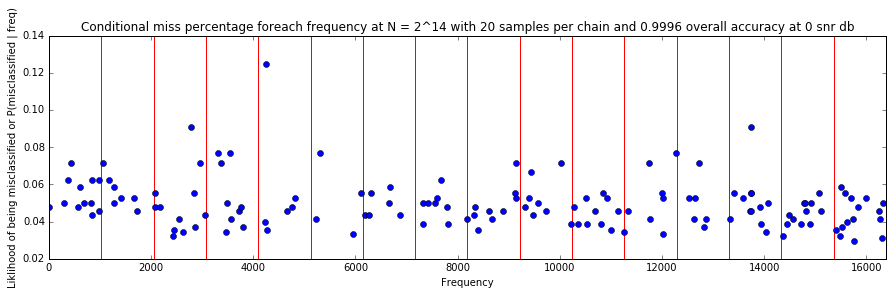

In [60]:
for wrongs, acc, num_pairs in zip(total_wrongs, accs, pairs_per_chains):
    error_thresh = 0.00
    large_wrongs, large_index = [], []
    for i in range(len(wrongs)):
        if wrongs[i] > error_thresh:
            large_index.append(i)
            large_wrongs.append(wrongs[i])
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(111)
    ax.set_xlim(0, N)
    ax.set_xlabel('Frequency') 
    ax.set_ylabel('Liklihood of being misclassified or P(misclassified | freq)')
    for i in range(5):
        for k in range((2 ** i)):
            ax.axvline(x = k * (N // (2 ** i)), color='red')
    ax.plot(large_index, large_wrongs, 'bo')
    ax.set_title('Conditional miss percentage foreach frequency at N = 2^{} with {} samples per chain and {} overall accuracy at {} snr db'.format(n, num_pairs, round(acc, 4), snrdb))
    plt.show()

I do not know what these are below here

In [5]:
def test_mse(w0,N,snrdb,ITER):
    signal = make_signal(w0,0,N)
    mse = 0
    sigma2 = get_sigma2_from_snrdb(snrdb)
    for i in range(ITER):
        noise = make_noise(sigma2, N)
        noisy_signal = signal + noise    
        w_est = kays_method(noisy_signal)
        squared_error = (w_est - w0)**2
        mse += squared_error/ITER
    return mse

In [6]:
# kay's plots
w0 = 2*np.pi*0.05
N  = 24

mse = test_mse(w0, N, 10, 400)

10*np.log10(1/mse)

43.03748725580676